In [1]:
import requests
from bs4 import BeautifulSoup

In [2]:
# get webpage with all packages
r = requests.get('https://conda-forge.org/feedstocks/')

# check the status code returned
r.status_code

200

In [3]:
# parse the response to get package names
soup = BeautifulSoup(r.content, "lxml")
table = soup.find("section", {"id": "feedstocks"})
links = [a['href'] for a in table.findAll('a')]

# inspect the links
links[:3]

['https://github.com/conda-forge/ablog-feedstock',
 'https://github.com/conda-forge/absl-py-feedstock',
 'https://github.com/conda-forge/ad3-cpp-feedstock']

In [4]:
# grab just the package names from the links
packages = [line.split('/')[-1].replace('-feedstock', '') for line in links]

# inspect the packages
packages[:3]

['ablog', 'absl-py', 'ad3-cpp']

In [7]:
# iterate over packages and get the grab meta.yaml
meta = {}
for pkg in packages:
    meta[pkg] = {}
    url = 'https://raw.githubusercontent.com/conda-forge/{}-feedstock/master/recipe/meta.yaml'.format(pkg)
    r = requests.get(url)
    if r.status_code == 200:
        meta[pkg]['response'] = r.text
    else:
        print("Error with {}".format(pkg))

Error with r-abind
Error with r-suppdists
Error with trilinos


In [8]:
# insepct one package
meta['ablog']

{'response': '{% set name = "ablog" %}\n{% set version = "0.9.2" %}\n{% set sha256 = "4027fbf75826bac4ad413eb5c8ab8e21bfe8e8c2635a07d9326873d9f14a27b7" %}\n\npackage:\n  name: {{ name|lower }}\n  version: {{ version }}\n\nsource:\n  fn: {{ name }}-{{ version }}.tar.gz\n  url: https://pypi.io/packages/source/{{ name[0] }}/{{ name }}/{{ name }}-{{ version }}.tar.gz\n  sha256: {{ sha256 }}\n\nbuild:\n  noarch: python\n  number: 1\n  script: python -m pip install --no-deps --ignore-installed .\n  entry_points:\n    - ablog = ablog.commands:ablog_main\n\nrequirements:\n  build:\n    - python\n    - pip\n  run:\n    - python\n    - werkzeug\n    - sphinx >=1.6\n    - alabaster\n    - invoke\n    - python-dateutil\n    - sphinx-automodapi\n\ntest:\n  requires:\n    - git\n  commands:\n    - ablog --version\n    - git clone --depth 1 --branch v{{ version }} https://github.com/sunpy/ablog\n    - cd ablog/docs\n    - ablog build -T\n    - ablog build -b latex -T -d .doctrees -w _latex\n    - abl

In [41]:
# find where the maintainers line starts
for pkg in meta:

    if meta[pkg] == {}:
        del meta[pkg]
    
    else:
        text = meta[pkg]['response'].split('\n')
        for i, line in enumerate(text):
            if 'recipe-maintainers' in line:
                break

        # grab the text from the maintainers section
        maintainers = text[i+1: ]

        # clean up the maintainers text
        maintainers_clean = []
        for m in maintainers:
            line = m.strip()
            if line != '' and not line.startswith('#'):
                maintainers_clean.append(line.replace('-', '').replace(' ', ''))

        # store the maintainers in meta dict
        meta[pkg]['maintainers'] = maintainers_clean

In [70]:
import networkx as nx
from networkx.algorithms import bipartite

# add packages and maintainers to a bipartite graph
B = nx.Graph()

# add packages
packages = set()
for pkg in meta.keys():
    if pkg != '':
        packages.add(pkg)
B.add_nodes_from(packages, bipartite=0)

# add authors
authors = set()
for pkg in meta.keys():
    for maintainer in meta[pkg]['maintainers']:
        if maintainer != '':
            authors.add(maintainer)
B.add_nodes_from(authors, bipartite=1)

# add edges
edges = []
for pkg in meta:
    for maintainer in meta[pkg]['maintainers']:
        edges.append((pkg, maintainer))
B.add_edges_from(edges)

In [71]:
# inspect the packages
list(packages)[:5]

['r-bookdown', 'xorg-libxaw', 'r-deldir', 'rt1', 'tenacity']

In [72]:
# inspect the authors
list(authors)[:5]

['elatt', 'kayhayen', 'ACBlock', 'ChrisRackauckas', 'gnestor']

In [73]:
# inspect the edges
edges[:5]

[('terraform-provider-cloudflare', 'sodre'),
 ('r-hmisc', 'johanneskoester'),
 ('r-hmisc', 'bgruening'),
 ('r-bookdown', 'johanneskoester'),
 ('r-bookdown', 'bgruening')]

In [74]:
# check if the graph is connected
nx.is_connected(B)

False

In [75]:
# grab the largest component
nx.number_connected_components(B)

201

In [76]:
# project bipartitle graph
G = bipartite.weighted_projected_graph(B, authors)

In [79]:
# grab the largest component
G = max(nx.connected_component_subgraphs(G), key=len)

In [80]:
# inspect the edges
list(G.edges(data=True))[:5]

[('ericdill', 'rmax', {'weight': 1}),
 ('ericdill', 'decarlof', {'weight': 5}),
 ('ericdill', 'wyseguy7', {'weight': 5}),
 ('ericdill', 'tacaswell', {'weight': 27}),
 ('ericdill', 'ocefpaf', {'weight': 3})]

In [137]:
# example provided by http://datashader.org/user_guide/7_Networks.html

import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

In [117]:
# put nodes into a DataFrame
nodes = pd.DataFrame([(node) for node in G.nodes], columns=['name'])

# create a copy of the index
nodes['index_copy'] = nodes.index

nodes.head()

,name,index_copy
0,ericdill,0
1,kayhayen,1
2,heidiaclayton,2
3,ACBlock,3
4,gnestor,4


In [130]:
# put edges into a DataFrame
edges = pd.DataFrame(list(G.edges), columns=['source', 'target'])

# replace name with id
edges1 = pd.merge(edges, nodes, left_on='source', right_on='name')
edges1 = edges1.rename({'index_copy': 'source_id'}, axis=1)
edges2 = pd.merge(edges1, nodes, left_on='target', right_on='name')
edges2 = edges2.rename({'index_copy': 'target_id'}, axis=1)

# subset to columns and rename
edges = edges2[['source_id', 'target_id']]
edges = edges.rename({'source_id': 'source', 'target_id': 'target'}, axis=1)

# drop the index_copy column
nodes.drop('index_copy', axis=1, inplace=True)

In [131]:
circular  = circular_layout(nodes, uniform=False)
randomloc = random_layout(nodes)
randomloc.tail()

,name,x,y
664,CamDavidsonPilon,0.372963,0.785538
665,jsiirola,0.110794,0.741480
666,eugeneburger,0.338793,0.371631
667,pahaz,0.571644,0.871133
668,LukeC92,0.244004,0.141057


Random layout,Circular layout

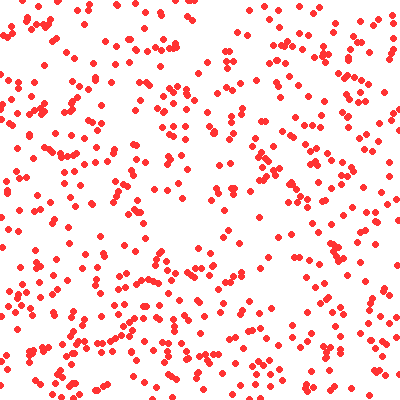
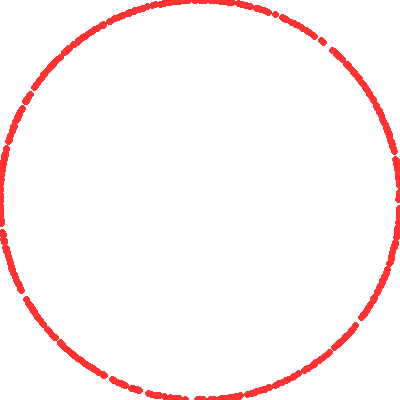

In [132]:
cvsopts = dict(plot_height=400, plot_width=400)

def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

tf.Images(nodesplot(randomloc,"Random layout"),
          nodesplot(circular, "Circular layout"))

CPU times: user 3.37 s, sys: 16 ms, total: 3.38 s
Wall time: 3.38 s


ForceAtlas2 layout

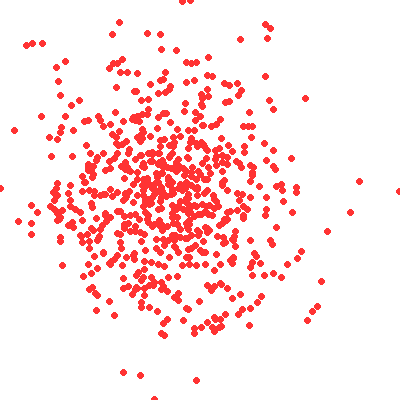

In [133]:
%time forcedirected = forceatlas2_layout(nodes, edges)
tf.Images(nodesplot(forcedirected, "ForceAtlas2 layout"))

In [134]:
def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(**cvsopts, x_range=xr, y_range=yr)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    ep = edgesplot(edges, name + " edges", canvas)
    return tf.stack(ep, np, how="over", name=name)

CPU times: user 1.12 s, sys: 8 ms, total: 1.12 s
Wall time: 1.12 s
CPU times: user 732 ms, sys: 0 ns, total: 732 ms
Wall time: 732 ms
CPU times: user 6.91 s, sys: 36 ms, total: 6.94 s
Wall time: 6.94 s
CPU times: user 3.71 s, sys: 24 ms, total: 3.73 s
Wall time: 3.73 s


Circular layout,Force-directed
"Circular layout, bundled","Force-directed, bundled"

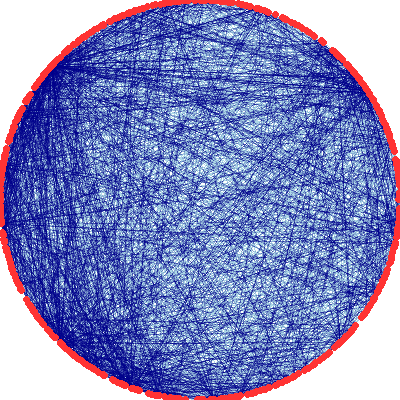
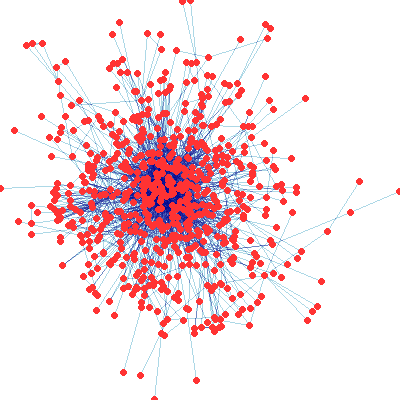
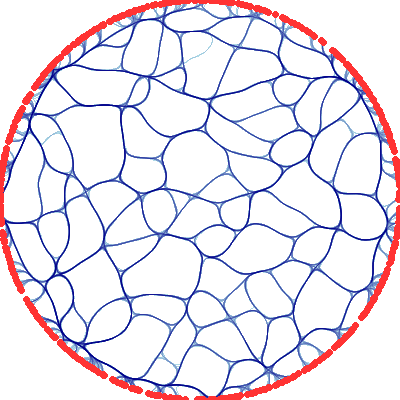
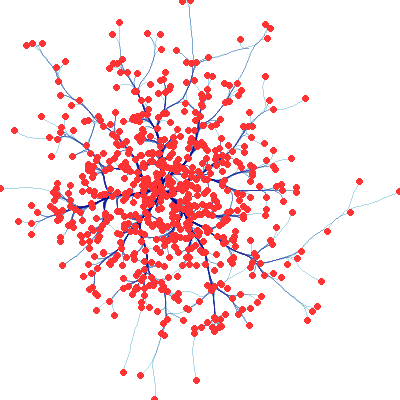

In [135]:
cd = circular
fd = forcedirected

%time cd_d = graphplot(cd, connect_edges(cd,edges), "Circular layout")
%time fd_d = graphplot(fd, connect_edges(fd,edges), "Force-directed") 
%time cd_b = graphplot(cd, hammer_bundle(cd,edges), "Circular layout, bundled")
%time fd_b = graphplot(fd, hammer_bundle(fd,edges), "Force-directed, bundled") 

tf.Images(cd_d,fd_d,cd_b,fd_b).cols(2)


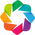

In [139]:
import holoviews as hv
hv.extension('bokeh')

In [156]:
%opts Nodes Graph [width=800 height=600 xaxis=None yaxis=None]

In [ ]:
%%opts Graph [color_index='circle']
%%opts Graph (node_size=10 edge_line_width=1)
graph = hv.Graph.from_networkx(G, nx.kamada_kawai_layout(G))
graph = graph.redim.range(x=(-0.05, 1.05), y=(-0.05, 1.05))

graph

In [158]:
from holoviews.operation.datashader import datashade, bundle_graph

bundled = bundle_graph(graph)
bundled

:Graph   [start,end]